# test controller

maps/shared_room_map.mat
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      144
Number of nonzeros in inequality constraint Jacobian.:      185
Number of nonzeros in Lagrangian Hessian.............:      192

Total number of variables............................:       75
                     variables with only lower bounds:       11
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       86
        inequality constraints with only lower bounds:       55
   inequality constraints with lower and upper bounds:       31
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alp

[1.25, 1.0, 0.674741, 1.0]This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      144
Number of nonzeros in inequality constraint Jacobian.:      185
Number of nonzeros in Lagrangian Hessian.............:      192

Total number of variables............................:       75
                     variables with only lower bounds:       11
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       86
        inequality constraints with only lower bounds:       55
   inequality constraints with lower and upper bounds:       31
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) al

INFO: Precompiling module PyPlot.
INFO: Installing matplotlib via the Conda matplotlib package...


Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /Users/changliu/.julia/v0.6/Conda/deps/usr:

The following NEW packages will be INSTALLED:

    cycler:       0.10.0-py27_0    
    freetype:     2.5.5-2          
    libpng:       1.6.27-0         
    matplotlib:   2.0.2-np113py27_0
    pytz:         2017.2-py27_0    
    subprocess32: 3.2.7-py27_0     

libpng-1.6.27- 100% |###############################| Time: 0:00:00   2.00 MB/s
freetype-2.5.5 100% |###############################| Time: 0:00:00   3.70 MB/s
pytz-2017.2-py 100% |###############################| Time: 0:00:00   3.05 MB/s
subprocess32-3 100% |###############################| Time: 0:00:00   9.76 MB/s
cycler-0.10.0- 100% |###############################| Time: 0:00:00  12.67 MB/s
matplotlib-2.0 100% |###############################| Time: 0:00:01   4.66 MB/s###                         | Time: 0:00:00   4.05 MB/sib-2.0  60% |##################          

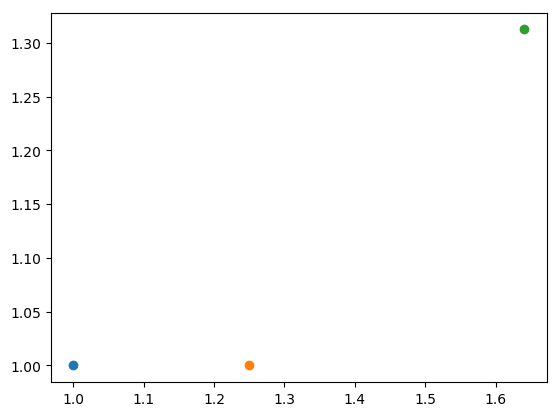

/Users/changliu/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# Test script for controller.jl without using the ROS part
push!(LOAD_PATH,pwd())
using CarMpcUtils
using CarMpc

# ################
# ##### Setup #####
# ################

### Simulation parameters
simLength = 2

## initialize vehicle
robot = Robot([1.0, 1.0, 0.0, 0.5], model=unicycleDiscrete)

## tuning parameters
tuning = Tuning(dt = 0.5, N = 10, safe_dis = 1.0, safe_margin = 1.0, cmft_dis = 2.4)

## map
# Map = TrackMap("maps/RFS_2Lanes_Speed_0128.mat")
field = Field("maps/shared_room_map.mat")

## obstacles
human = Array{Obstacle}(2,1) # this actually comes from ROS message
human[1] = Obstacle([5.0,5.0,0.0,0.0],"circle",0.0)
human[2] = Obstacle([6.0,6.0,0.0,0.0],"circle",0.0)
obs = Array{Obstacle}(2,1)
obs[1] = Obstacle([3.0,5.0,0.0,0.0],"circle",0.0)
obs[2] = Obstacle([2.0,2.0,0.0,0.0],"circle",0.0)

# ################
# ##### Main #####
# ################

# ### Initialize MPC problem and solve dummy problem
mpc = initializeMPCProblem(robot, human, obs, field, tuning)
nz, nu, N = mpc.nz, mpc.nu, tuning.N

# ### MPC model parameters updated by subscribers
z0 = robot.z
u0 = zeros(nu)
z_h = zeros(8,N+1)

USim = zeros(nu,simLength)
ZSim = [z0 zeros(nz,simLength)]

### Main loop
for t=1:simLength
  ### Update and solve MPC problem
    ZOpt, UOpt, solveTime = updateSolveMpcProblem(mpc, z0, z_h)

  ### Update current input
  u0[1:nu] = UOpt[:,1]

  ### Update ego state
  # updateEgoState!(vehicle,u0,tuning.dtMPC)
  updateEgoState!(robot,u0,tuning.dt)

  ### Variables for logging
  ZSim[:,t+1] = robot.z
  USim[:,t] = u0
    print(robot.z)
end

using PyPlot
figure()
# plot(Map.nodes[1,:]',Map.nodes[2,:]')
plot(ZSim[1,:]',ZSim[2,:]',marker="o")
show()